In [3]:
import sys
#sys.path.insert(0,'/home/eric/Documents/Thesis/analysisCode/EAST/')
sys.path.insert(0, '/mnt/c/Users/Shawn/Documents/GitHub/d3dscripts/2020/02/')
#this is the location of functionDoc.py which I gave you

In [2]:
from functionDoc import *
#directory of the SOLPS output
#rundir = '/home/eric/Documents/Thesis/analysisCode/runs/NSTX/204202.00561/release307Branch_Dpuff/forLaura/'
#rundir = '/mnt/c/Users/Shawn/Documents/d3d_work/SOLPS Runs/AUG_16151_D/16151_1.6MW_2.0e19_D=0.4_chi=1.6_pump=0.90/'
rundir = '/mnt/c/Users/Shawn/Documents/d3d_work/vas_solps_runs/Donly_gradb_revBt/'
# directory to save plots, I don't have it saving anything right now so I don't need it
# if you want it to save something look at plotvar and you can see the input for turning on saving
# plotdir = '/home/eric/Documents/Thesis/analysisCode/NSTX/plots/204202.00461_D_vlctLimit/heatDiffScan8_Pin=2.25_radialTC_mpi_fromScratch/'
colors = ['r','b','k','m','c','g','y']

#location of the SOLPS data for each file

#these two are B2 files
b2fstateLoc = rundir+'b2fstate'
b2fgmtryLoc = rundir+'b2fgmtry'
b2fplasmfLoc = rundir+'b2fplasmf'

#These five are EIRENE files
ft33Loc = rundir+'fort.33'
ft34Loc = rundir+'fort.34'
ft35Loc = rundir+'fort.35'
ft44Loc = rundir+'fort.44'# these are the EIRENE quantities projected onto the B2 grid
ft46Loc = rundir+'fort.46'

# reading the data with these functions
# returns a class which we can call parameters from
b2fstate = read_b2fstate(b2fstateLoc)
b2fgmtry = read_b2fgmtry(b2fgmtryLoc)
dims = np.shape(b2fstate.na)
b2fplasmf = read_b2fplasmf(b2fplasmfLoc,dims[0]-2,dims[1]-2,dims[2])
# The extra dimension input is to account for the guard cells
ft44 = read_ft44(ft44Loc)

read_b2fstate -- file version 03.000.006
done reading state file
read_b2fgmtry -- file version 03.000.006
done reading geometry file
read_b2fplasmf -- file version 03.000.00
done reading b2fplasmf
read_ft44: assuming nlwrmsh = 1, nfla = 1.
read_ft44: unknown format of fort.44 file
done reading ft44 file


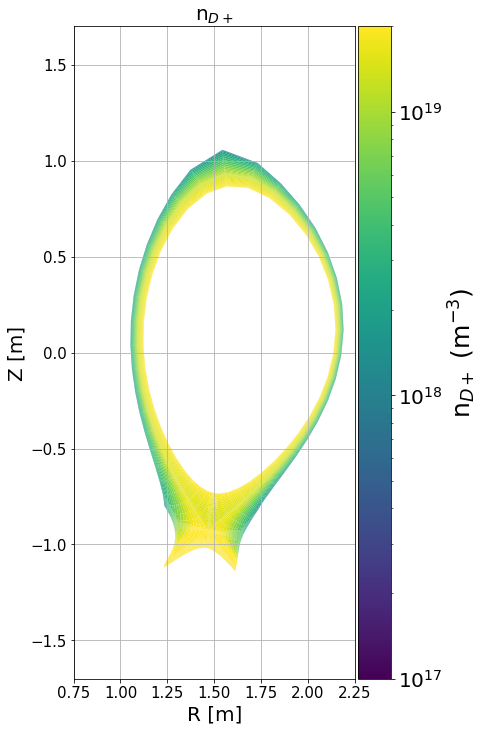

In [12]:
# plotting the D+ density, the third index is the species but this run only has D0 and D+
# the D0 in the B2 quantities is basically nothing because that information is handled by eirene
# so you pretty much always slice along index 1 in the third index
plotvar(b2fgmtry.crx,b2fgmtry.cry,b2fstate.na[:,:,1],minColor=1e17,maxColor=2e19,cbScale='log',
        cbTitle=r'n$_{D+}$ (m$^{-3}$)',title='n$_{D+}$',
        xlims=[0.75,2.25],ylims=[-1.7,1.7])

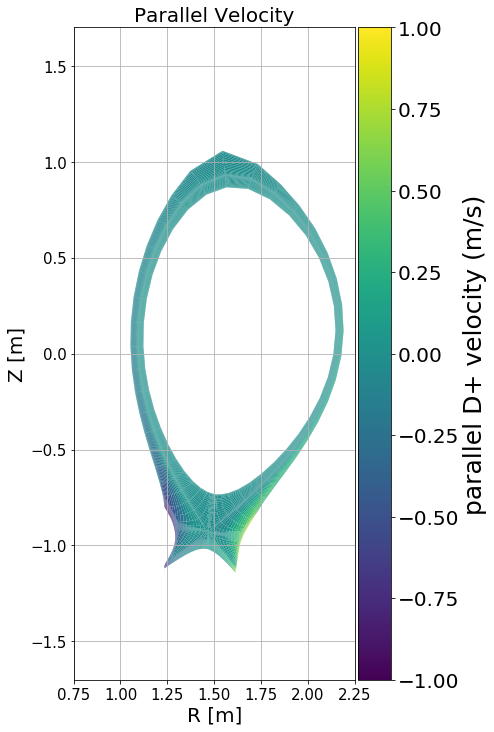

In [16]:
# this is another example of how to plot a variable
# I also calculate the mach number as SOLPS does
# because it is not outputted in the output files
vth=np.zeros(np.shape(b2fstate.na[:,:,1]))
vel=np.zeros(np.shape(b2fstate.na[:,:,1]))
for iS in range(np.shape(b2fstate.na)[2]):
    if (is_neutral(iS)): continue
    rza=b2fstate.zamin[iS]
    am=b2fstate.am[iS]
    te=b2fstate.te
    ti=b2fstate.ti
    ne=b2fstate.ne
#     ni=b2fplasmf.ni[:,:,1]
    ni=b2fstate.na[:,:,iS]
    na=b2fstate.na[:,:,iS]
    ua=b2fstate.ua[:,:,iS]
    vth=vth+na*(rza*te+ti)/(am*ni*mn)
    vel=vel+ua*rza*na/ne
vth=np.sqrt(vth)
mach = (vel/vth)

plotvar(b2fgmtry.crx,b2fgmtry.cry,mach,minColor=-1,maxColor=1,cbScale='linear',
        cbTitle='parallel D+ velocity (m/s)',title='Parallel Velocity',
        xlims=[0.75,2.25],ylims=[-1.7,1.7])

In [17]:
ft46 = read_ft46(ft46Loc)
triMesh  = read_triangle_mesh(ft33Loc,ft34Loc,ft35Loc)

done reading ft46 file
read_ft33: assuming ntrfrm = 0.


(7886, 1)


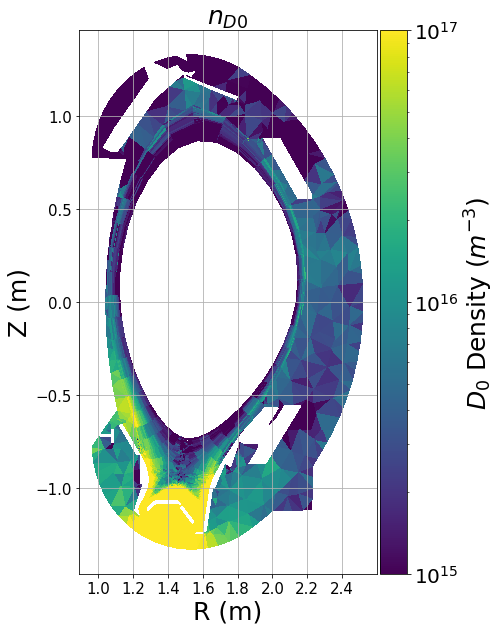

In [18]:
# This is how I do a color plot of the eirene quantities

#plot inputs
maxColor=1e17
minColor=1e15

xMin =0.4
xMax = 0.8
yMin = 1.0
yMax = 1.5

x = triMesh.nodes.T[:,0]
y = triMesh.nodes.T[:,1]

z = ft46.pdena[:,0]#asking for first atom (the only atom in fact)
print(np.shape(ft46.pdena))#should be shape of nTriangles x number of atoms

triangles = triMesh.cells.T-1
plt.figure(figsize=(6,10))
plt.tripcolor(x,y,triangles,facecolors=z,norm=colorsMPL.LogNorm(vmin=minColor, vmax=maxColor),cmap='viridis')
cb = plt.colorbar(fraction=0.1, pad=0.01)
cb.ax.tick_params(labelsize=20)
cb.set_label(r'$D_0$ Density $(m^{-3})$',fontsize=25)
# plt.xlim([xMin,xMax])
# plt.ylim([yMin,yMax])
plt.grid()
plt.title(r'$n_{D0}$',fontsize=25)
plt.xlabel('R (m)',fontsize=25)
plt.ylabel('Z (m)',fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(rundir+'D2density.png')
plt.show()

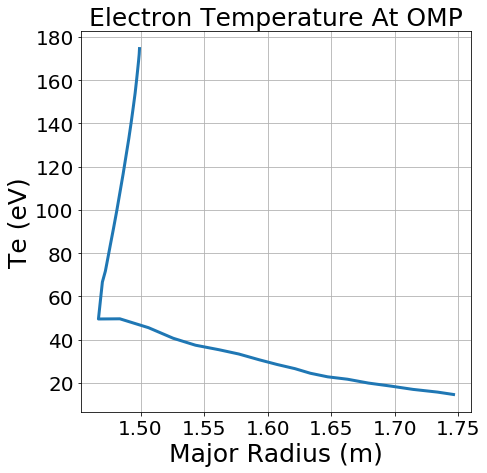

In [19]:
# Here's how to slice at the OMP

# Let's grab the OMP x-index which happens to be 71 for this case
# in SOLPS x-index is the poloidal index, y-index is the radial
# We will also cut off the guard cells by removing the first and last indices of the array
plt.figure(figsize=(7,7))
plt.plot(b2fgmtry.crx[:,:,0][b2fgmtry.leftix==71][1:-1],b2fstate.te[b2fgmtry.leftix==71][1:-1]/1.6e-19,linewidth=3)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Te (eV)',fontsize=25)
plt.xlabel('Major Radius (m)',fontsize=25)
plt.title('Electron Temperature At OMP',fontsize=25)
plt.show()

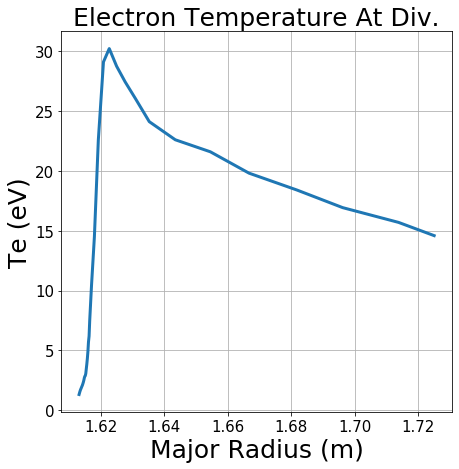

In [20]:
# Here's how to slice at the lower outer divertor

# Let's grab the divertor x-index which happens to be 95 for this case
plt.figure(figsize=(7,7))
plt.plot(b2fgmtry.crx[:,:,0][b2fgmtry.leftix==95][1:-1],b2fstate.te[b2fgmtry.leftix==95][1:-1]/1.6e-19,linewidth=3)
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Te (eV)',fontsize=25)
plt.xlabel('Major Radius (m)',fontsize=25)
plt.title('Electron Temperature At Div.',fontsize=25)
plt.show()

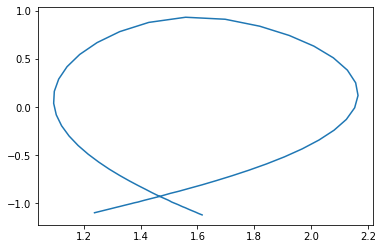

In [27]:
import matplotlib.pyplot as plt
iy=18
plt.plot(b2fgmtry.crx[:,:,0][b2fgmtry.leftiy==iy], b2fgmtry.cry[:,:,0][b2fgmtry.leftiy==iy])

In [3]:
b2fstate.na[:,:,1].shape

(98, 38)